## MSH integration to Python routing framework with a simple test domain (i.e., three reaches with a single junction)

Author: Dong Ha Kim, NOAA's Office of Water Prediction, National Water Center

1) Fortran source codes: 

    -directory: src/fortran_routing/msh_pylink_v00/msh_mSeg_sTS/
    -codes: var.f90
            subtools.f90
            inival.f90
            sec.f90
            matrix.f90
            predictor.f90
            corrector.f90
            
            
2) Geospatial data input directory: test/input/geo/PoconoSample3R1J
    - Two upper reaches with three segments each and one lower reach with four segments

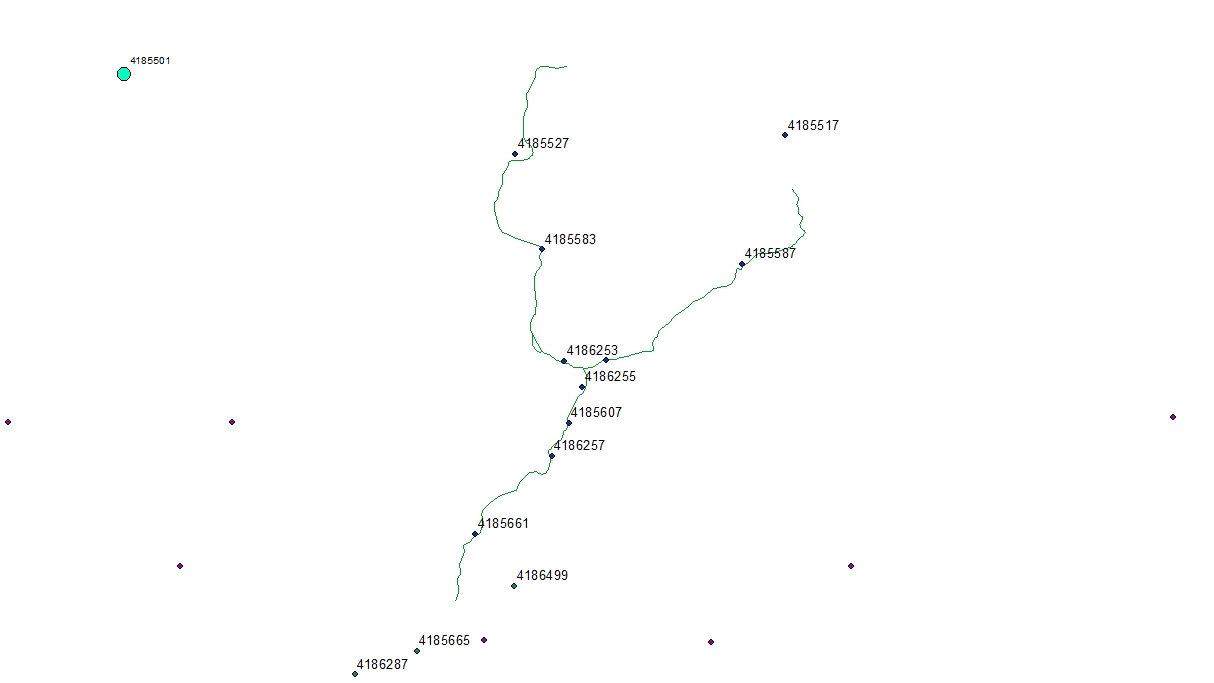


###    *** Note ***

MSH code here modified by the author based on the original code developed by Dr.Ehab Meselhe still need to be corrected or updated for numerical stability. In fact, the code implmented here is unstable after a couple hundred of time steps. This publication of code is only for understanding how MSH scheme is implemented throughout NHD network using Python routing framework developed by James Halgren.

Ongoing works for solving the unstability include:
    
    - correct the equations of I2 and dI2/dA
    - stable boundary conditions
    - modify Sf (energy gradient)
    - modify NHD channel attributes including reach lenghts and channel bottom elevation especially at junctions


    

In [1]:
## Basic imports
import sys
import os
import time

# WARNING: These global declarations cause the parallel implementation to 
# crash when executed on Windows
connections = None
networks = None
flowdepthvel = None

from sys import platform
if platform == "linux" or platform == "linux2":
    pass
elif platform == "darwin":
    pass
elif platform == "win32":
    print('The parallel version of compute_nhd_routing.py will not execute as currently')
    print('written due to the lack of a fork() capability in the windows OS.')
    print('For parallel execution, please us a *nix OS.')
    print('\nexiting...')
    sys.exit()
    # Some useful references:
    # https://stackoverflow.com/questions/985281/what-is-the-closest-thing-windows-has-to-fork/985525#985525
    # https://stackoverflow.com/questions/8220108/how-do-i-check-the-operating-system-in-python
    # https://stackoverflow.com/questions/6596617/python-multiprocess-diff-between-windows-and-linux

ENV_IS_CL = False
if ENV_IS_CL: root = '/content/t-route/'
elif not ENV_IS_CL: 
    sys.setrecursionlimit(4000)
#     root = os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))
    root = os.path.dirname(os.path.dirname(os.path.abspath('')))
    sys.path.append(os.path.join(root, r'src', r'python_framework'))
    sys.path.append(os.path.join(root, r'src', r'python_routing')) #by Dong Ha
    fortran_source_dir = os.path.join(root, r'src', r'fortran_routing', r'msh_pylink_v00', r'msh_mSeg_sTS')
    sys.path.append(fortran_source_dir)
    
## F2PY Muskingum Cunge module
# mc_f2py= True
# if mc_f2py:
#     try:
#         import subprocess

#         f2py_call = []
#         f2py_call.append(r'f2py3')
#         f2py_call.append(r'-c')
#         f2py_call.append(r'varSingleSegStime_f2py_noIC_clean.f90')
#         f2py_call.append(r'MCsingleSegStime_f2py_noIC_clean.f90')
#         f2py_call.append(r'-m')
#         f2py_call.append(r'mc_sseg_stime_noIC')
#         subprocess.run(f2py_call, cwd=r'../fortran_routing/mc_pylink_v00/MC_singleSeg_singleTS',
#                        stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
#     except Exception as e:
#         print(e)
## network and reach utilities
import nhd_network_utilities as nnu
import nhd_reach_utilities as nru
# import channel_routing_tools as crt
import numpy as np
import msh
import pixiedust

Pixiedust database opened successfully


In [3]:
#%%pixie_debugger
if 1==1:
#def main():

    global connections
    global networks
    #global flowdepthvel
    global ydaq
    global mshpara
                      
    verbose = True
    debuglevel = 0
    showtiming = True

    test_folder = os.path.join(root, r'test')
    geo_input_folder = os.path.join(test_folder, r'input', r'geo', r'Channels')

    #TODO: Make these commandline args
    supernetwork= 'Pocono_TEST3_3R1J'
    """##NHD Subset (Brazos/Lower Colorado)"""
#     supernetwork = 'Brazos_LowerColorado_ge5'
    """##NHD CONUS order 5 and greater"""
    # supernetwork = 'CONUS_ge5'
    """These are large -- be careful"""                          
#     supernetwork = 'Mainstems_CONUS'
    # supernetwork = 'CONUS_FULL_RES_v20'
    # supernetwork = 'CONUS_Named_Streams' #create a subset of the full resolution by reading the GNIS field
    # supernetwork = 'CONUS_Named_combined' #process the Named streams through the Full-Res paths to join the many hanging reaches

    if verbose: print('creating supernetwork connections set')
    if showtiming: start_time = time.time()
    #STEP 1
    supernetwork_data, supernetwork_values = nnu.set_networks(
        supernetwork = supernetwork
        , geo_input_folder = geo_input_folder
        , verbose = False
        # , verbose = verbose
        , debuglevel = debuglevel
        )
    if verbose: print('supernetwork connections set complete')
    if showtiming: print("... in %s seconds." % (time.time() - start_time))

    #STEP 2
    if showtiming: start_time = time.time()
    if verbose: print('organizing connections into networks and reaches ...')
    networks = nru.compose_reaches(
        supernetwork_values
        , verbose = False
        # , verbose = verbose
        , debuglevel = debuglevel
        , showtiming = showtiming
        )
    if verbose: print('reach organization complete')
    if showtiming: print("... in %s seconds." % (time.time() - start_time))
    

    #STEP 3: Route NHD streamflow
    if showtiming: start_time = time.time()
    executiontype = 'serial' # 'parallel'

    if verbose: print('executing serial computation on ordered reaches ...')
    connections = supernetwork_values[0]

    nts = 100  # number fof timestep = 1140 * 60(model timestep) = 86400 = day
    dt_msh= 2.0 # time interval for MC
    
#     flowdepthvel = {connection:{'flow':np.zeros(nts)
#                                 , 'depth':np.zeros(nts)
#                                 , 'vel':np.zeros(nts)
#                                 , 'qlat':np.zeros(nts)}
#                                for connection in connections}  
    ydaq = {connection:{'y':np.zeros(nts)
                        ,'depth':np.zeros(nts)
                        ,'area':np.zeros(nts)
                        ,'q':np.zeros(nts)}
                        for connection in connections} 
    qlat = {connection:{'lateral inflow':np.zeros(nts)
                        } for connection in connections}                       
    q_hbseg={connection:{'q_headbasin segment':np.zeros(nts)
                          } for (connection, cv) in connections.items() 
                        if cv['upstreams']=={0}}
#     mxncomp=10
#     mshpara={connection:{'areap':np.zeros((mxncomp))
#                         ,'qp':np.zeros(mxncomp)
#                         ,'dap':np.zeros(mxncomp)
#                         ,'dqp':np.zeros(mxncomp)
#                         ,'dac':np.zeros(mxncomp)
#                         ,'dqc':np.zeros(mxncomp)}
#                         for connection in connections} 
    mshpara={connection:{'areap':np.zeros((1))
                        ,'qp':np.zeros(1)
                        ,'dap':np.zeros(1)
                        ,'dqp':np.zeros(1)
                        ,'dac':np.zeros(1)
                        ,'dqc':np.zeros(1)}
                        for connection in connections} 

    # downstream boundary segment ID
    dbsegID= 4185661
    d_dbseg={dbsegID:{'depth_dsbd segment':np.zeros(nts)}}
#     print(d_dstseg)
                              
    #test1:
    for ts in range(0,nts):
        # given discharges at headbasin segments
        q_hbseg[4185527]['q_headbasin segment'][ts]=10.0
        q_hbseg[4185517]['q_headbasin segment'][ts]=12.0
        # given stage at downstream terminal segment
        d_dbseg[dbsegID]['depth_dsbd segment'][ts]=6.57422
    #

    if executiontype == 'serial':
        iter=0
        for terminal_segment, network in networks.items():
            if showtiming: network_start_time = time.time()
            iter=iter+1
            print(f"terminal_segment iter-> {iter}")
            ##------------------------------------------------------------------------
            ## Compute ordered_reaches and last_segment_reach for all the segments of
            ## reach referenced by head_segment
            ##------------------------------------------------------------------------
            ordered_reaches = {}
            # Start: By Dong Ha
            last_segment_reach={}
            lsegs_usrch={}
            
            print(f"network['reaches']: {network['reaches'][4185527]['reach_tail']}")
            print()

            for head_segment, reach in network['reaches'].items():
                if reach['seqorder'] not in ordered_reaches:
                    ordered_reaches.update({reach['seqorder']:[]}) #TODO: Should this be a set/dictionary?
                # ordered_reaches contains network dictionary values according to seqorder (= 
                # the number of juctions downstream).
                ordered_reaches[reach['seqorder']].append([head_segment, reach])
                      
                # Start: By Dong Ha
                # last_segment_reach stores {head_segment:lastseg} where head_segment and lastseg are
                # the first and last segment ID of a given reach
                #seg_list=list(reach['segments_list'])
                #lastseg=seg_list[0]
                #last_segment_reach[head_segment]= lastseg
                last_segment_reach[head_segment]= reach['reach_tail']
#                 print(f"head_segment: {head_segment} last_segment_reach: {last_segment_reach}")  
#                 print()
#                 print(f"head_segment: {head_segment} reach: {reach}")
            

#             head_segment=4185527
#             dsrchID= network['reaches'][head_segment]['downstream_reach']
#             print()
#             print(f"head_seg: {head_segment}  dsrchID {dsrchID}")
#             ds_usrchID= network['reaches'][dsrchID]['upstream_reaches']
#             print()
#             print(f"head_seg: {head_segment}  ds_usrchID {ds_usrchID}")
#             print()
#             for rchID in ds_usrchID:
#                 print(f"lseg_ds_usrchID: {network['reaches'][rchID]['reach_tail']}")
#                 print()

                #print(last_segment_reach)-> {4186255: 4185661, 4185517: 4186251, 4185527: 4186253}
#             print()
#             print(f"ordered_reaches->{ordered_reaches}")
#             print()

            #---------------------------------------------------------------------------------------------------

            #           Estimate the values of q for every segment at the simulation start time (ts=0)
            #           p.F<->P_init.cond.-1
 
            #---------------------------------------------------------------------------------------------------
            #Note that not networks but network that takes networks values corresponding to 'terminal_segment' keys.
            #Also, network here takes 'terminal_segment' key only at the lower end of a network.      
            for ts in range (0,1):
                for x in range(network['maximum_reach_seqorder'],-1,-1):       
                    for head_segment, reach in ordered_reaches[x]:
                
               #output: reach -> {'reach_tail': 4186251, 'downstream_reach': 4186255, 'reach_head': 4185517, 
                #          'seqorder':1,'segments': {4186251, 4185517, 4185587}, 
                #          'segments_list': [4186251, 4185587, 4185517], 
                #          'upstream_reaches': {0}}
                    
                        seg_list=list(reach['segments_list'])
                        seg_list=seg_list[::-1] #to reversed order
                        ncomp= len(reach['segments_list'])
                        q=np.zeros(ncomp)
                         # Test1: Lateral inflow arbitarily computed
                        for seg in range(0,ncomp):
                            segID= seg_list[seg]
                            qlat[segID]['lateral inflow'][ts]=0.5*(float(seg)+1.0)
                            print(f"segID->{segID} qlat -> {qlat[segID]['lateral inflow'][0]}")
                        print()
        #                 print(f"qlat -> {qlat}")
                        print()
                        # At headbasin segment
                        if reach['upstream_reaches']=={0}:        
                            # known discharge at headbasin segment at time ts
                            q[0]= q_hbseg[head_segment]['q_headbasin segment'][ts]
                            for seg in range(0,ncomp):
                                segID= seg_list[seg]
                                q[seg]= q[0] + qlat[segID]['lateral inflow'][ts]                      
                                ydaq[segID]['q'][ts]= q[seg]
                                print(f"headbasin seg: segID->{segID} qall-> {ydaq[segID]['q'][0]}")
                        # At a junction
                        else:
                            # add qs of the last segments of all upstream reaches
                            qjt=0.0
                            usrch_list=list(reach['upstream_reaches'])
                            usrchnb= len(reach['upstream_reaches'])                        
                            for usrch in range(0,usrchnb):
                                uslsegID= last_segment_reach[usrch_list[usrch]] 
                                qjt= qjt + ydaq[uslsegID]['q'][ts]
                            # cascade the accumulated q at a junction down to the downream segments
                            q[0]= qjt
                            for seg in range(0,ncomp):
                                segID= seg_list[seg]
                                q[seg]= q[0] + qlat[segID]['lateral inflow'][ts]                      
                                ydaq[segID]['q'][ts]= q[seg]
                                print(f"junction: segID->{segID} qall-> {ydaq[segID]['q'][0]}")
            #---------------------------------------------------------------------------------------------------

            #           Estimate the values of y for every segment at the simulation start time (ts=0)
            #           p.F<->P_init.cond.-2

            #---------------------------------------------------------------------------------------------------                              
                for x in range(0,network['maximum_reach_seqorder']+1):       
                    for head_segment, reach in ordered_reaches[x]:                    
                        seg_list0=list(reach['segments_list'])
                        seg_list=seg_list0[::-1] #to reversed order
                        print()
                        print(f"x-> {x}; head_segment->{head_segment}")
                        print()

                        # At downstream boundary segment
                        if seg_list0.count(dbsegID)>0:
                            # identify where dsbdID is located along the given reach, and count 
                            # segments upward from the dsbdID segment.
                            ncomp= len(seg_list0)
                            idx= seg_list0.index(dbsegID)
                            ncomp= ncomp-idx
                            msh.var.ncompy=ncomp
                            msh.var.y=np.zeros(ncomp)
                            msh.var.q=np.zeros(ncomp)
                            # channel data variable
                            msh.var.z=np.zeros(ncomp)
                            msh.var.bo=np.zeros(ncomp)
                            msh.var.traps=np.zeros(ncomp)
                            msh.var.tw=np.zeros(ncomp)
                            msh.var.twcc=np.zeros(ncomp)                              
                            # channel data input
                            for seg in range(0,ncomp):
                                segID= seg_list[seg] 
                                msh.var.z[seg]=connections[segID]['data'][supernetwork_data['alt_col']]
                                msh.var.bo[seg]=connections[segID]['data'][supernetwork_data['bottomwidth_col']]
                                msh.var.traps[seg]=connections[segID]['data'][supernetwork_data['ChSlp_col']]
                                msh.var.tw[seg]=connections[segID]['data'][supernetwork_data['topwidth_col']]
                                msh.var.twcc[seg]=connections[segID]['data'][supernetwork_data['topwidthcc_col']]

                                msh.var.q[seg]= ydaq[segID]['q'][ts]
                            # known depth at downstream boundary segment at time ts
                            depth= d_dbseg[dbsegID]['depth_dsbd segment'][ts]
                            msh.var.y[ncomp-1]= depth + msh.var.z[ncomp-1]

                            msh.ini.iniydsbd()

                            for seg in range(0,ncomp):
                                segID= seg_list[seg] 
                                ydaq[segID]['y'][ts]= msh.var.y[seg]
                                ydaq[segID]['depth'][ts]= msh.var.y[seg]-msh.var.z[seg]
                                print(f"dsbd segID -> {segID} :  depth-> {ydaq[segID]['depth'][0]}")
                         # At a junction
                        else:
                            # compute y of a reach tht has downstream reach through a junction
                            # downstream reach ID, that is, the first segment ID of the reach
                            dsrchID= reach['downstream_reach']
                            depth= ydaq[dsrchID]['depth'][ts]
                            ncomp= len(seg_list)
                            msh.var.ncompy =ncomp
                            msh.var.y=np.zeros(ncomp)
                            # channel data
                            msh.var.z=np.zeros(ncomp)
                            msh.var.bo=np.zeros(ncomp)
                            msh.var.traps=np.zeros(ncomp)
                            msh.var.tw=np.zeros(ncomp)
                            msh.var.twcc=np.zeros(ncomp)

                            for seg in range(0,ncomp):
                                segID= seg_list[seg]
                                msh.var.z[seg]=connections[segID]['data'][supernetwork_data['alt_col']]
                                msh.var.bo[seg]=connections[segID]['data'][supernetwork_data['bottomwidth_col']]
                                msh.var.traps[seg]=connections[segID]['data'][supernetwork_data['ChSlp_col']]
                                msh.var.tw[seg]=connections[segID]['data'][supernetwork_data['topwidth_col']]
                                msh.var.twcc[seg]=connections[segID]['data'][supernetwork_data['topwidthcc_col']]
                                print(f'z-> {msh.var.z[seg]}')
                                msh.var.q[seg]= ydaq[segID]['q'][ts]
                            
                            msh.ini.iniy(depth)

                            for seg in range(0,ncomp):
                                segID= seg_list[seg] 
                                ydaq[segID]['y'][ts]= msh.var.y[seg]
                                ydaq[segID]['depth'][ts]= msh.var.y[seg]-msh.var.z[seg]
                                print(f"junction segID -> {segID} :  depth-> {ydaq[segID]['depth'][0]}")


                                #output: reach -> {'reach_tail': 4186251, 'downstream_reach': 4186255, 'reach_head': 4185517, 
                        #          'seqorder':1,'segments': {4186251, 4185517, 4185587}, 
                        #          'segments_list': [4186251, 4185587, 4185517], 
                        #          'upstream_reaches': {0}}


            msh.var.phi=1.0  # source term treatment (0:explicit, 1:implicit)
            msh.var.alfa2=0.5  # em parameter for artificial diffusion
            msh.var.alfa4=0.1  # maximum value for artificial diffusion
            msh.var.theta=1.0
            msh.var.thetas=1.0
            msh.var.thesinv=1.0
            msh.var.f=1.0  # SI units=1 
            msh.var.cfl=1.0 # courant nubmer for optimal optimization of dt
            msh.var.ots=0 # optimize dt (1:apply opt, !=1: user specify)
            msh.var.eqn_A=1 # equations for deriving A matrix (0:orignal, 1:diffrent)
            msh.var.dtini= dt_msh
            
            for ts in range (0,nts-1):
            #---------------------------------------------------------------------------------------------------

            #                                               PREDICTOR

            #---------------------------------------------------------------------------------------------------
            #Note that not networks but network that takes networks values corresponding to 'terminal_segment' keys.
            #Also, network here takes 'terminal_segment' key only at the l 
                for x in range(network['maximum_reach_seqorder'],-1,-1):       
                    for head_segment, reach in ordered_reaches[x]:  
                        seg_list0=list(reach['segments_list'])
                        seg_list=seg_list0[::-1] #to reversed order
                        #print()
                        #print(f"x-> {x}; head_segment->{head_segment}")
                        #print()

                        # the number of segments of a given reach 
                        ncomp= len(seg_list0)
                        # check if there is a downstream boundary segment in the given reach.
                        if seg_list0.count(dbsegID)>0:
                            # identify where dsbdID is located along the given reach, and count 
                            # segments upward from the dsbdID segment.                    
                            idx= seg_list0.index(dbsegID)
                            ncomp= ncomp-idx

                        # msh variable initialization
                        msh.var.ityp = np.ones(ncomp)             
                          # fortran: y, q, area , dap, dqp, dac, dqc, areap, qp
                        msh.var.ncompy =ncomp
                        msh.var.y =np.zeros(ncomp)
                        msh.var.area =np.zeros(ncomp)
                        msh.var.q =np.zeros(ncomp)
                        msh.var.areap =np.zeros(ncomp)
                        msh.var.qp =np.zeros(ncomp)
                        msh.var.dap =np.zeros(ncomp)
                        msh.var.dqp =np.zeros(ncomp)
                        msh.var.dac =np.zeros(ncomp)
                        msh.var.dqc =np.zeros(ncomp)
                          # fortran: ynp1, qnp1, ynm1, dt, qlat
                        msh.var.ynp1 =np.zeros(ncomp)
                        msh.var.qnp1 =np.zeros(ncomp)
                        #msh.var.ynm1 =np.zeros(ncomp)
                        msh.var.dt =np.zeros(ncomp)
                        msh.var.qlat =np.zeros(ncomp)               
                        # channel data variable
                          # fortran: dx, z, bo, traps, sk, chbtslp      
                        msh.var.dx =np.zeros(ncomp)
                        msh.var.z =np.zeros(ncomp)
                        msh.var.bo =np.zeros(ncomp)
                        msh.var.traps =np.zeros(ncomp)
                        msh.var.sk =np.zeros(ncomp)                                
                        msh.var.chbtslp =np.zeros(ncomp)                              
                          # fortran: Tw, TwCC, skCC1, skCC2          
                        msh.var.tw=np.zeros(ncomp)
                        msh.var.twcc=np.zeros(ncomp)
                        msh.var.skcc1=np.zeros(ncomp)
                        msh.var.skcc2=np.zeros(ncomp)
                        # feed data into fortran variables
                        for seg in range(0,ncomp):
                            segID= seg_list[seg] 

                            # msh varialbes
                            msh.var.y[seg]= ydaq[segID]['y'][ts]          
                            msh.var.q[seg]= ydaq[segID]['q'][ts]

                            # channel data variables
                            msh.var.dx[seg]=connections[segID]['data'][supernetwork_data['length_col']]
                            msh.var.z[seg]=connections[segID]['data'][supernetwork_data['alt_col']]
                            msh.var.bo[seg]=connections[segID]['data'][supernetwork_data['bottomwidth_col']]
                            msh.var.traps[seg]=connections[segID]['data'][supernetwork_data['ChSlp_col']]
                            msh.var.chbtslp[seg]=connections[segID]['data'][supernetwork_data['slope_col']]
                            msh.var.tw[seg]=connections[segID]['data'][supernetwork_data['topwidth_col']]
                            msh.var.twcc[seg]=connections[segID]['data'][supernetwork_data['topwidthcc_col']]
                            sk =connections[segID]['data'][supernetwork_data['manningn_col']]
                            skcc1 =connections[segID]['data'][supernetwork_data['manningncc_col']]
                            skcc2 =connections[segID]['data'][supernetwork_data['manningncc_col']]          
                            msh.var.sk[seg]=1.0/sk
                            msh.var.skcc1[seg]= 1.0/skcc1
                            msh.var.skcc2[seg]= 1.0/skcc2

                            # Test1: Lateral inflow arbitarily computed                              
                            qlat[segID]['lateral inflow'][ts]=0.5*(float(seg)+1.0)
                            msh.var.qlat[seg]= qlat[segID]['lateral inflow'][ts]
                            #print(f"segID->{segID} qlat -> {qlat[segID]['lateral inflow'][0]}")

        #             ,'key_col' : 18
        #             , 'downstream_col' : 23
        #             , 'length_col' : 5
        #             , 'manningn_col' : 20
        #             , 'manningncc_col' : 21
        #             , 'slope_col' : 10
        #             , 'bottomwidth_col' : 2
        #             , 'topwidth_col' : 11
        #             , 'topwidthcc_col' : 12
        #             , 'alt_col': 13
        #             , 'MusK_col' : 6
        #             , 'MusX_col' : 7
        #             , 'ChSlp_col' : 3                   
        #               # given discharges at headbasin segments
        #         q_hbseg[4185527]['q_headbasin segment'][ts]=10.0
        #         q_hbseg[4185517]['q_headbasin segment'][ts]=12.0
        #         # given stage at downstream terminal segment
        #         d_dbseg[dbsegID]['depth_dsbd segment'][ts]=6.57422                        

                        msh.var.usbdflag=0
                        msh.var.dsbdflag=0
                        if reach['upstream_reaches']=={0}:        
                            # upstream boundary condition with known discharge at headbasin segment 
                            msh.var.usbdflag=1
                            # measured q at headbasin segments at time n and n+1
                            msh.var.msrq= q_hbseg[head_segment]['q_headbasin segment'][ts]
                            msh.var.msrqnp1= q_hbseg[head_segment]['q_headbasin segment'][ts+1]        

                            if ts==0:
                                msh.var.ynm1= ydaq[segID]['y'][ts]
                            else:
                                msh.var.ynm1= ydaq[segID]['y'][ts-1]        

                        elif seg_list.count(dbsegID)>0:
                            # downstream boundary condition at a segment of dsbdID along a current reach
                            msh.var.dsbdflag=1
                            msh.var.msrh= d_dbseg[dbsegID]['depth_dsbd segment'][ts]
                            msh.var.msrhnp1= d_dbseg[dbsegID]['depth_dsbd segment'][ts+1]         

                        if reach['upstream_reaches']=={0}: 

                            # step1: no need to run junction boudary condition

                            # step2: 
                            msh.predictor.main()

                        else:
                            # step1: junction boundary condition-> dqp[0] & dap[0]
                            areasum= 0.0
                            qsum=0.0         
                            usrch_list=list(reach['upstream_reaches'])
                            usrchnb= len(usrch_list)              
                            for usrch in range(0,usrchnb):
                                # last segment ID of an upstream reach through a juction
                                uslsegID= last_segment_reach[usrch_list[usrch]] 
                                areasum= areasum + ydaq[uslsegID]['area'][ts] + mshpara[uslsegID]['dap'][0]
                                #qsum= qsum + ydaq[uslsegID]['q'][ts] + mshpara[uslsegID]['dqp'][0]

                            dqp=0.0
                            hav=0.0
                            for usrch in range(0,usrchnb):
                                # last segment ID of an upstream reach through a juction
                                uslsegID= last_segment_reach[usrch_list[usrch]] 
                                # add dqp of the last segments of the upstream reaches at n
                                dqp= dqp + mshpara[uslsegID]['dqp'][0]
                                areak_ncomp= ydaq[uslsegID]['area'][ts] + mshpara[uslsegID]['dap'][0]
                                #qk_ncomp= ydaq[uslsegID]['q'][ts] + mshpara[uslsegID]['dqp'][0]
                                # channel data of the last segment of upstream reach
                                bxs= connections[uslsegID]['data'][supernetwork_data['bottomwidth_col']]
                                ssxs= connections[uslsegID]['data'][supernetwork_data['ChSlp_col']]
                                twxs= connections[uslsegID]['data'][supernetwork_data['topwidth_col']]
                                twccxs= connections[uslsegID]['data'][supernetwork_data['topwidthcc_col']]
                                axs= areak_ncomp
                                #hxs= 0.01 #initialize
                                hk_ncomp=msh.subtools.depthcalc3(bxs,ssxs,twxs,twccxs,axs) #,hxs)

                                #hk_ncomp= msh.var.sbtoolrst
                                # weighted average based on areas at the last nodes of upstream link ks
                                
                                hav= hav + (areak_ncomp/areasum)*hk_ncomp                                # weighted average based on qs at the last nodes of upstream link ks      
                                #hav = hav + (qk_ncomp/qsum)*hk_ncomp                             
                            msh.var.dqp[0]=dqp
                            # channel data of the first segment of the current reach
                            bxs=msh.var.bo[0]
                            ssxs= msh.var.traps[0]
                            twxs= msh.var.tw[0]
                            twccxs= msh.var.twcc[0]
                            #axs= 0.01 #initialize
                                      
                            axsnp1=msh.subtools.areacalc2(bxs, ssxs, twxs, twccxs, hav) #, axs) 
                                      
                            #axsnp1= msh.var.sbtoolrst                                    
                            ## In fortran, this juction boudary condition is treated 
                            # after calling sub section, which computes area values, 
                            # while area values are not known yet here. Thus, the 
                            # area of this head_segment needs to be computed for this
                            # line.
                            hxs= ydaq[head_segment]['y'][ts] - msh.var.z[0]
                            
                            axs=msh.subtools.areacalc2(bxs, ssxs, twxs, twccxs, hxs) 
                                      
                            #axs= msh.var.sbtoolrst  
                                      
                            msh.var.dap[0]= axsnp1 - axs #ydaq[head_segment]['area'][ts]

                            #step2:
                            msh.predictor.main()
                        # store predictor outputs
                        for seg in range(0,ncomp):
                            segID= seg_list[seg] 
                            ydaq[segID]['area'][ts]= msh.var.area[seg]
                            mshpara[segID]['dap'][0]= msh.var.dap[seg]
                            mshpara[segID]['dqp'][0]= msh.var.dqp[seg]
                            mshpara[segID]['areap'][0]= msh.var.areap[seg]
                            mshpara[segID]['qp'][0]= msh.var.qp[seg]
                            mshpara[segID]['dac'][0]= msh.var.dac[seg]
                            mshpara[segID]['dqc'][0]= msh.var.dqc[seg]
                            print(f"ts:{ts} segID:{segID} mshpara:{mshpara[segID]}")
                            print()
                                      
                            # msh varialbes
#                             msh.var.y[seg]= ydaq[segID]['y'][ts]  
#                    mshpara={connection:{'areap':np.zeros((1))
#                         ,'qp':np.zeros(1)
#                         ,'dap':np.zeros(1)
#                         ,'dqp':np.zeros(1)
#                         ,'dac':np.zeros(1)
#                         ,'dqc':np.zeros(1)}
#                         for connection in connections} 
  
            #---------------------------------------------------------------------------------------------------

            #                                           CORRECTOR

            #---------------------------------------------------------------------------------------------------
            #Note that not networks but network that takes networks values corresponding to 'terminal_segment' keys.
            #Also, network here takes 'terminal_segment' key only at the
                for x in range(0, network['maximum_reach_seqorder']+1):       
                    for head_segment, reach in ordered_reaches[x]:  
                        seg_list0=list(reach['segments_list'])
                        seg_list=seg_list0[::-1] #to reversed order
                        #print()
                        print(f"x-> {x}; head_segment->{head_segment}")
                        #print()

                        # the number of segments of a given reach 
                        ncomp= len(seg_list0)
                        # check if there is a downstream boundary segment in the given reach.
                        if seg_list0.count(dbsegID)>0:
                            # identify where dsbdID is located along the given reach, and count 
                            # segments upward from the dsbdID segment.                    
                            idx= seg_list0.index(dbsegID)
                            ncomp= ncomp-idx

                        # msh variable initialization
                        msh.var.ityp = np.ones(ncomp)             
                          # fortran: y, q, area , dap, dqp, dac, dqc, areap, qp
                        msh.var.ncompy =ncomp
                        msh.var.y =np.zeros(ncomp)
                        msh.var.area =np.zeros(ncomp)
                        msh.var.q =np.zeros(ncomp)
                        msh.var.areap =np.zeros(ncomp)
                        msh.var.qp =np.zeros(ncomp)
                        msh.var.dap =np.zeros(ncomp)
                        msh.var.dqp =np.zeros(ncomp)
                        msh.var.dac =np.zeros(ncomp)
                        msh.var.dqc =np.zeros(ncomp)
                          # fortran: ynp1, qnp1, ynm1, dt, qlat
                        msh.var.ynp1 =np.zeros(ncomp)
                        msh.var.qnp1 =np.zeros(ncomp)
                        #msh.var.ynm1 =np.zeros(ncomp)
                        msh.var.dt =np.zeros(ncomp)
                        msh.var.qlat =np.zeros(ncomp)               
                        # channel data variable
                          # fortran: dx, z, bo, traps, sk, chbtslp      
                        msh.var.dx =np.zeros(ncomp)
                        msh.var.z =np.zeros(ncomp)
                        msh.var.bo =np.zeros(ncomp)
                        msh.var.traps =np.zeros(ncomp)
                        msh.var.sk =np.zeros(ncomp)                                
                        msh.var.chbtslp =np.zeros(ncomp)                              
                          # fortran: Tw, TwCC, skCC1, skCC2          
                        msh.var.tw=np.zeros(ncomp)
                        msh.var.twcc=np.zeros(ncomp)
                        msh.var.skcc1=np.zeros(ncomp)
                        msh.var.skcc2=np.zeros(ncomp)
                        # feed data into fortran variables
                        for seg in range(0,ncomp):
                            segID= seg_list[seg] 

                            # msh varialbes
                            msh.var.y[seg]= ydaq[segID]['y'][ts]          
                            msh.var.q[seg]= ydaq[segID]['q'][ts]
                            msh.var.area[seg] = ydaq[segID]['area'][ts]
                            msh.var.areap[seg] = mshpara[segID]['areap'][0]
                            msh.var.qp[seg] = mshpara[segID]['qp'][0]
                            msh.var.dap[seg]= mshpara[segID]['dap'][0]
                            msh.var.dqp[seg] = mshpara[segID]['dqp'][0]
                            msh.var.dac[seg] = mshpara[segID]['dac'][0]
                            msh.var.dqc[seg] = mshpara[segID]['dqc'][0]

                            # channel data variables
                            msh.var.dx[seg]=connections[segID]['data'][supernetwork_data['length_col']]
                            msh.var.z[seg]=connections[segID]['data'][supernetwork_data['alt_col']]
                            msh.var.bo[seg]=connections[segID]['data'][supernetwork_data['bottomwidth_col']]
                            msh.var.traps[seg]=connections[segID]['data'][supernetwork_data['ChSlp_col']]
                            msh.var.chbtslp[seg]=connections[segID]['data'][supernetwork_data['slope_col']]
                            msh.var.tw[seg]=connections[segID]['data'][supernetwork_data['topwidth_col']]
                            msh.var.twcc[seg]=connections[segID]['data'][supernetwork_data['topwidthcc_col']]
                            sk =connections[segID]['data'][supernetwork_data['manningn_col']]
                            skcc1 =connections[segID]['data'][supernetwork_data['manningncc_col']]
                            skcc2 =connections[segID]['data'][supernetwork_data['manningncc_col']]          
                            msh.var.sk[seg]=1.0/sk
                            msh.var.skcc1[seg]= 1.0/skcc1
                            msh.var.skcc2[seg]= 1.0/skcc2

                            # Test1: Lateral inflow arbitarily computed                              
                            #qlat[segID]['lateral inflow'][ts]=0.5*(float(seg)+1.0)
                            msh.var.qlat[seg]= qlat[segID]['lateral inflow'][ts]
                            #print(f"segID->{segID} qlat -> {qlat[segID]['lateral inflow'][0]}")

                     

#                         msh.var.usbdflag=0
#                         msh.var.dsbdflag=0
#                         if reach['upstream_reaches']=={0}:        
#                             # upstream boundary condition with known discharge at headbasin segment 
#                             msh.var.usbdflag=1
#                             # measured q at headbasin segments at time n and n+1
#                             msh.var.msrq= q_hbseg[head_segment]['q_headbasin segment'][ts]
#                             msh.var.msrqnp1= q_hbseg[head_segment]['q_headbasin segment'][ts+1]        

#                             if ts==0:
#                                 msh.var.ynm1= ydaq[segID]['y'][ts]
#                             else:
#                                 msh.var.ynm1= ydaq[segID]['y'][ts-1]        

#                         elif seg_list.count(dbsegID)>0:
#                             # downstream boundary condition at a segment of dsbdID along a current reach
#                             msh.var.dsbdflag=1
#                             msh.var.msrh= d_dbseg[dbsegID]['depth_dsbd segment'][ts]
#                             msh.var.msrhnp1= d_dbseg[dbsegID]['depth_dsbd segment'][ts+1]         

                        ## begin: for test
#                         msh.var.cop =np.zeros(ncomp)
#                         msh.var.ci1p =np.zeros(ncomp) 
#                         msh.var.gsop =np.zeros(ncomp) 
#                         msh.var.depthp =np.zeros(ncomp)
#                         msh.var.b11p =np.zeros(ncomp) 
#                         msh.var.b12p =np.zeros(ncomp) 
#                         msh.var.b21p =np.zeros(ncomp) 
#                         msh.var.b22p =np.zeros(ncomp) 
#                         msh.var.g11invp =np.zeros(ncomp)      
#                         msh.var.g12invp =np.zeros(ncomp)                          
#                         msh.var.g21invp =np.zeros(ncomp)      
#                         msh.var.g22invp =np.zeros(ncomp)  
#                         msh.var.f1p =np.zeros(ncomp)               
#                         msh.var.f2p =np.zeros(ncomp) 
#                         msh.var.d1p =np.zeros(ncomp) 
#                         msh.var.d2p =np.zeros(ncomp) 
#                         msh.var.up =np.zeros(ncomp) 
#                         msh.var.cp=np.zeros(ncomp) 
#                         msh.var.a11p  =np.zeros(ncomp) 
#                         msh.var.a12p =np.zeros(ncomp) 
#                         msh.var.a21p =np.zeros(ncomp) 
#                         msh.var.a22p  =np.zeros(ncomp) 
#                         msh.var.st11p =np.zeros(ncomp) 
#                         msh.var.st12p =np.zeros(ncomp) 
#                         msh.var.st21p =np.zeros(ncomp) 
#                         msh.var.st22p =np.zeros(ncomp)
#                         msh.var.courp =np.zeros((ncomp,5)) 
                        ## end : for test
                        
                        if ((reach['downstream_reach']=={0}) or (seg_list.count(dbsegID)>0)): 

                            # step1: no need to run junction boudary condition

                            # step2: 
                            msh.corrector.main()

                        else:
                            # step1: junction boundary condition-> dqc[ncomp] & dac[ncomp]
                            #areasum= 0.0
                            #qsum=0.0 
                            # head_segment ID of downstream reach
                            dsfsegID=reach['downstream_reach']             
#                             usrch_list=list(reach['upstream_reaches'])
#                             usrchnb= len(usrch_list)              
#                             for usrch in range(0,usrchnb):
#                                 # last segment ID of an upstream reach through a juction
#                                 uslsegID= last_segment_reach[usrch_list[usrch]] 
#                                 areasum= areasum + ydaq[uslsegID]['area'][ts] + mshpara[uslsegID]['dap'][0]
#                                 #qsum= qsum + ydaq[uslsegID]['q'][ts] + mshpara[uslsegID]['dqp'][0]
                            # compute dac[ncomp]
                            area_ds= ydaq[dsfsegID]['area'][ts]
                            dap_ds= mshpara[dsfsegID]['dap'][0]
                            dac_ds= mshpara[dsfsegID]['dac'][0]
                            areacr= area_ds + 0.5*(dap_ds + dac_ds)
                            # channel data of the head_segment of the downstream reach
                            bxs= connections[dsfsegID]['data'][supernetwork_data['bottomwidth_col']]
                            ssxs= connections[dsfsegID]['data'][supernetwork_data['ChSlp_col']]
                            twxs= connections[dsfsegID]['data'][supernetwork_data['topwidth_col']]
                            twccxs= connections[dsfsegID]['data'][supernetwork_data['topwidthcc_col']]
                            #axs= areacr
                            h1z= msh.subtools.depthcalc3(bxs,ssxs,twxs,twccxs,areacr)
                            
                            ncompm1= ncomp-1
                            bxs= msh.var.bo[ncompm1]
                            ssxs= msh.var.traps[ncompm1]
                            twxs= msh.var.tw[ncompm1]
                            twccxs= msh.var.twcc[ncompm1]
                            
                            axs=msh.subtools.areacalc2(bxs, ssxs, twxs, twccxs, h1z)
                                      
                            msh.var.dac[ncompm1]= 2.0*(axs - msh.var.area[ncompm1]) - msh.var.dap[ncompm1]
                            
                            # compute dqc[ncomp]
                            qsum= 0.0
                            dsrchID= network['reaches'][head_segment]['downstream_reach']
                            usrchID_ds= network['reaches'][dsrchID]['upstream_reaches']
                            for rchID in usrchID_ds:
                                lsegID= network['reaches'][rchID]['reach_tail']
                                qsum= qsum + mshpara[lsegID]['qp'][0]
                            
                            qnp1_ds= ydaq[dsfsegID]['q'][ts] + 0.5*(mshpara[dsfsegID]['dqp'][0] \
                                                                    +mshpara[dsfsegID]['dqc'][0])
                            qnp1_us= qnp1_ds*msh.var.qp[ncompm1]/qsum
                            msh.var.dqc[ncompm1]= 2.0*(qnp1_us - msh.var.q[ncompm1]) - msh.var.dqp[ncompm1]
                            
                            # step2: 
                            msh.corrector.main()
                        
                        # store corrector outputs
                        for seg in range(0,ncomp):
                            segID= seg_list[seg] 
                            ydaq[segID]['y'][ts+1]= msh.var.ynp1[seg]
                            ydaq[segID]['q'][ts+1]= msh.var.qnp1[seg]
                            mshpara[segID]['dac'][0]= msh.var.dac[seg]
                            mshpara[segID]['dqc'][0]= msh.var.dqc[seg]
                            print(f"ts:{ts} segID:{segID} y_n+1:{ydaq[segID]['y'][ts+1]} \
                                                          q_n+1:{ydaq[segID]['q'][ts+1]}")
                            print() 
                                      
                                      
#           
                            # msh varialbes
#                             msh.var.y[seg]= ydaq[segID]['y'][ts]  
#                    mshpara={connection:{'areap':np.zeros((1))
#                         ,'qp':np.zeros(1)
#                         ,'dap':np.zeros(1)
#                         ,'dqp':np.zeros(1)
#                         ,'dac':np.zeros(1)
#                         ,'dqc':np.zeros(1)}
#                         for connection in connections} 
  
    
                              
                              
# head_segment-> 4185527 reach-> {'reach_tail': 4186253, 'downstream_reach': 4186255, 'reach_head': 4185527, 
#                                 'seqorder': 4, 'segments': {4185527, 4186253, 4185583}, 
#                                 'segments_list': [4186253, 4185583, 4185527], 'upstream_reaches': {0}}
                              
                              
# head_segment-> 4186255 reach-> {'reach_tail': 4185661, 'downstream_reach': 4185665, 'reach_head': 4186255, 
#                                 'seqorder': 3, 'segments': {4186255, 4186257, 4185661, 4185607}, 
#                                 'segments_list': [4185661, 4186257, 4185607, 4186255], 
#                                 'upstream_reaches': {4185517, 4185527}}
                    

                                  
                              
                              
# head_segment-> 4185527 reach-> {'reach_tail': 4186253, 'downstream_reach': 4186255, 'reach_head': 4185527, 
#                                 'seqorder': 4, 'segments': {4185527, 4186253, 4185583}, 
#                                 'segments_list': [4186253, 4185583, 4185527], 'upstream_reaches': {0}}
                              
                              
# head_segment-> 4186255 reach-> {'reach_tail': 4185661, 'downstream_reach': 4185665, 'reach_head': 4186255, 
#                                 'seqorder': 3, 'segments': {4186255, 4186257, 4185661, 4185607}, 
#                                 'segments_list': [4185661, 4186257, 4185607, 4186255], 
#                                 'upstream_reaches': {4185517, 4185527}}
                    

                              

    
    
#             compute_network(
#                 terminal_segment = terminal_segment
#                 , network = network
#                 , supernetwork_data = supernetwork_data
#                 , nts = nts #number_of_time_steps
# #                 , connections = connections
#                 , verbose = False
#                 , debuglevel = debuglevel
#             )
#             ## run MSH to route network 
#             msh_route_network(                  
#                         terminal_segment = terminal_segment
#                         , network = network
#                         , supernetwork_data = supernetwork_data
#                         , nts = nts
#                         , dt_msh= dt_msh
#                         , qlat= qlat
#                         , usbd= q_hbseg
#                         , dsbd= d_dbseg
#                         , dsbdID= dbsegID
#                         , verbose = False
#                         , debuglevel = 0
#                         )


 
                      
#             if verbose: print(f'{terminal_segment} completed')
#             if showtiming: print("... in %s seconds." % (time.time() - network_start_time))
        
#     if verbose: print('ordered reach computation complete')
#     if showtiming: print("... in %s seconds." % (time.time() - start_time))

creating supernetwork connections set
supernetwork connections set complete
... in 0.025966167449951172 seconds.
organizing connections into networks and reaches ...
reach organization complete
... in 0.00046753883361816406 seconds.
executing serial computation on ordered reaches ...
terminal_segment iter-> 1
network['reaches']: 4186253

segID->4185517 qlat -> 0.5
segID->4185587 qlat -> 1.0
segID->4186251 qlat -> 1.5


headbasin seg: segID->4185517 qall-> 12.5
headbasin seg: segID->4185587 qall-> 13.5
headbasin seg: segID->4186251 qall-> 14.0
segID->4185527 qlat -> 0.5
segID->4185583 qlat -> 1.0
segID->4186253 qlat -> 1.5


headbasin seg: segID->4185527 qall-> 10.5
headbasin seg: segID->4185583 qall-> 11.5
headbasin seg: segID->4186253 qall-> 12.0
segID->4186255 qlat -> 0.5
segID->4185607 qlat -> 1.0
segID->4186257 qlat -> 1.5
segID->4185661 qlat -> 2.0


junction: segID->4186255 qall-> 26.5
junction: segID->4185607 qall-> 27.5
junction: segID->4186257 qall-> 28.0
junction: segID->4185

ts:14 segID:4185517 y_n+1:611.9907836914062                                                           q_n+1:119.02339935302734

ts:14 segID:4185587 y_n+1:608.1092529296875                                                           q_n+1:185.5348358154297

ts:14 segID:4186251 y_n+1:585.032958984375                                                           q_n+1:192.50253295898438

x-> 1; head_segment->4185527
ts:14 segID:4185527 y_n+1:602.0988159179688                                                           q_n+1:111.61030578613281

ts:14 segID:4185583 y_n+1:599.0886840820312                                                           q_n+1:177.95030212402344

ts:14 segID:4186253 y_n+1:585.1829223632812                                                           q_n+1:177.11669921875

ts:15 segID:4185517 mshpara:{'areap': array([71.38777924]), 'qp': array([119.02339935]), 'dap': array([0.]), 'dqp': array([0.]), 'dac': array([0.]), 'dqc': array([0.])}

ts:15 segID:4185587 mshpara:{'areap': 

ts:32 segID:4186255 y_n+1:583.9735717773438                                                           q_n+1:655.9869384765625

ts:32 segID:4185607 y_n+1:582.7635498046875                                                           q_n+1:669.5025634765625

ts:32 segID:4186257 y_n+1:572.7785034179688                                                           q_n+1:666.7052001953125

ts:32 segID:4185661 y_n+1:568.7672729492188                                                           q_n+1:521.6558837890625

x-> 1; head_segment->4185517
ts:32 segID:4185517 y_n+1:613.7633056640625                                                           q_n+1:199.80825805664062

ts:32 segID:4185587 y_n+1:610.391845703125                                                           q_n+1:338.7187805175781

ts:32 segID:4186251 y_n+1:587.6035766601562                                                           q_n+1:345.7293701171875

x-> 1; head_segment->4185527
ts:32 segID:4185527 y_n+1:603.326171875              

ts:50 segID:4186255 y_n+1:586.3765258789062                                                           q_n+1:896.5659790039062

ts:50 segID:4185607 y_n+1:585.3753051757812                                                           q_n+1:964.4490966796875

ts:50 segID:4186257 y_n+1:575.912841796875                                                           q_n+1:1060.5208740234375

ts:50 segID:4185661 y_n+1:570.8490600585938                                                           q_n+1:803.7008056640625

x-> 1; head_segment->4185517
ts:50 segID:4185517 y_n+1:615.2276000976562                                                           q_n+1:240.03759765625

ts:50 segID:4185587 y_n+1:612.5155029296875                                                           q_n+1:471.6041564941406

ts:50 segID:4186251 y_n+1:590.0065307617188                                                           q_n+1:479.7281188964844

x-> 1; head_segment->4185527
ts:50 segID:4185527 y_n+1:604.1935424804688            

ts:68 segID:4185661 mshpara:{'areap': array([214.51371765]), 'qp': array([1123.95019531]), 'dap': array([4.04485989]), 'dqp': array([18.18752098]), 'dac': array([0.]), 'dqc': array([18.18752098])}

x-> 0; head_segment->4186255
ts:68 segID:4186255 y_n+1:588.3955688476562                                                           q_n+1:1079.524658203125

ts:68 segID:4185607 y_n+1:587.7376708984375                                                           q_n+1:1242.204833984375

ts:68 segID:4186257 y_n+1:578.881103515625                                                           q_n+1:1486.23583984375

ts:68 segID:4185661 y_n+1:573.0187377929688                                                           q_n+1:1123.9501953125

x-> 1; head_segment->4185517
ts:68 segID:4185517 y_n+1:616.2354736328125                                                           q_n+1:235.58419799804688

ts:68 segID:4185587 y_n+1:614.3661499023438                                                           q_n+1:588.

ts:86 segID:4185527 y_n+1:604.2092895507812                                                           q_n+1:-46.95220947265625

ts:86 segID:4185583 y_n+1:606.0353393554688                                                           q_n+1:543.1201782226562

ts:86 segID:4186253 y_n+1:593.60888671875                                                           q_n+1:511.31787109375

ts:87 segID:4185517 mshpara:{'areap': array([105.08231354]), 'qp': array([175.34057617]), 'dap': array([0.]), 'dqp': array([0.]), 'dac': array([0.]), 'dqc': array([0.])}

ts:87 segID:4185587 mshpara:{'areap': array([178.14579773]), 'qp': array([685.68255615]), 'dap': array([0.06741645]), 'dqp': array([5.76656437]), 'dac': array([0.]), 'dqc': array([0.])}

ts:87 segID:4186251 mshpara:{'areap': array([195.06655884]), 'qp': array([666.69512939]), 'dap': array([1.69953918]), 'dqp': array([13.12052917]), 'dac': array([0.]), 'dqc': array([0.])}

ts:87 segID:4185527 mshpara:{'areap': array([90.04720306]), 'qp': array([-46